## Load data

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

#mimic_data= pd.read_csv(r"mimic_cbc.csv", header=0)
data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data, None)

/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [3]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_gw_test = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_gw_test = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

# X_mimic = torch.tensor(data_analysis.get_X_mimic(), dtype=torch.long)
# y_mimic = torch.tensor(data_analysis.get_y_mimic(), dtype=torch.float)

In [4]:
# X_train = torch.concat((X_train, X_mimic))
# y_train = torch.concat((y_train, y_mimic))

In [5]:
# tried this without much success
def add_exponentiated_features():
    for i in range(X_train.shape[1]):
        X_train = torch.cat((X_train, torch.pow(X_train[:,i], 2).unsqueeze(1)), dim = 1)
        X_train = torch.cat((X_train, torch.pow(X_train[:,i], 3).unsqueeze(1)), dim = 1)
    
    for i in range(X_test.shape[1]):
        X_test = torch.cat((X_test, torch.pow(X_test[:,i], 2).unsqueeze(1)), dim = 1)
        X_test = torch.cat((X_test, torch.pow(X_test[:,i], 3).unsqueeze(1)), dim = 1)
    
    for i in range(X_gw_test.shape[1]):
        X_gw_test = torch.cat((X_gw_test, torch.pow(X_gw_test[:,i], 2).unsqueeze(1)), dim = 1)
        X_gw_test = torch.cat((X_gw_test, torch.pow(X_gw_test[:,i], 3).unsqueeze(1)), dim = 1)

## Normalize data

In [6]:
def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

X_train = normalize(X_train)
X_test = normalize(X_test)
X_gw_test = normalize(X_gw_test)

## Train/Validation split

In [7]:
def true_indices_like(tensor):
    return torch.ones((tensor.shape[0])).type(torch.bool)

def false_indices_like(tensor):
    return torch.zeros((tensor.shape[0])).type(torch.bool)

def split(train_features):
    tensor = true_indices_like(train_features)
    max_index = round(tensor.shape[0] * 0.8)
    train = torch.zeros(tensor.shape[0])
    train[:max_index] = 1
    
    val = torch.zeros(tensor.shape[0])
    val[max_index:] = 1
    return{
        "train": train.type(torch.bool),
        "val":val.type(torch.bool)
    }
X_train_clone = torch.clone(X_train)
y_train_clone = torch.clone(y_train)
train_data = split(X_train_clone)

train_mask = train_data["train"]
val_mask = train_data["val"]

X_train = X_train_clone[train_mask]
X_val = X_train_clone[val_mask]
y_train = y_train_clone[train_mask]
y_val = y_train_clone[val_mask]

## Define model

In [8]:
import torch.nn.functional as F
from torch.nn import Linear
import torch
from dataAnalysis.Constants import FEATURES

class NeuralNetwork(torch.nn.Module):

    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(NeuralNetwork, self).__init__()
        
        input_dim = len(FEATURES)
        self.lin_0 = Linear(input_dim, hidden_dim)
        self.lin_1 = Linear(input_dim, hidden_dim)
        self.lin_end_0 = Linear(hidden_dim, out_channels)
        self.lin_end_1 = Linear(hidden_dim, out_channels)
        self.batchnorm_1 = torch.nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = self.lin_0(x) + self.lin_1(x)
        x = F.normalize(x, p=2., dim=-1)
        x = torch.relu(x)
        x= self.batchnorm_1(x)
        x = self.lin_end_0(x) + self.lin_end_1(x) 
        return x
            
    def predict_proba(self, x):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(x)
            scores = torch.sigmoid(torch.squeeze(logits))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, x):
        return torch.round(self.predict_proba(x)[:, 1])

## Shift data to device

In [9]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

X_gw_test = X_gw_test.to(device)
y_gw_test = y_gw_test.to(device)

unique, counts = torch.unique(y_train, return_counts = True)
WEIGHT = torch.tensor([counts[0] / counts[1]])
print(WEIGHT)
# WEIGHT = torch.tensor([664])
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

tensor([667.9119])
Data shifted to the device cuda:0


## Model-Wrapper class

In [10]:
import torch 

class ModelWrapper():
    def __init__(self):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 10000

        self.model = NeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 5      
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            out = self.model(X_val)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out), y_val.type(torch.float32),
                                                      pos_weight=WEIGHT)
#             print(loss)
            if loss.item() > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = loss.item()

    def train(self):
        for epoch in range(self.MAX_EPOCHS):
#             print(epoch)
            self.model.train()
            self.optimizer.zero_grad()
            out = self.model(X_train)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out), y_train.type(torch.float32),
                                                      pos_weight=WEIGHT)
            loss.backward()
            self.optimizer.step()
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    

In [11]:
modelWrapper = ModelWrapper()
modelWrapper.train()

Breaked at 462


In [12]:
model = modelWrapper.get_model()

## Save model

In [13]:
# torch.save(model.state_dict(), "neural_network_state_dict.pt")

## Shift data and model back to CPU for evaluation

In [14]:
y_test = y_test.cpu()
X_test = X_test.cpu()

y_gw_test = y_gw_test.cpu()
X_gw_test = X_gw_test.cpu()
model = model.cpu()

In [15]:
X_test.shape

torch.Size([366284, 7])

## Evaluation

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.051419,0.790035,0.446226,0.009887,0.875784,0.015105
1,Greifswald,0.037801,0.805413,0.449530,0.006920,0.815421,0.005934


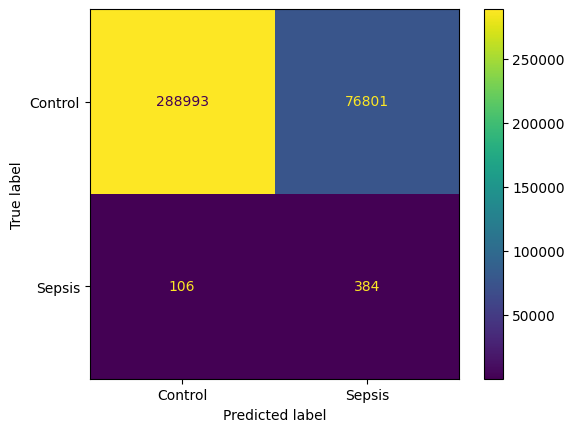

In [16]:
from dataAnalysis.Metrics import Evaluation

evaluation = Evaluation(y_test, y_gw_test, X_test, X_gw_test)
evaluation.plot_confusion_matrix(model)
evaluation.get_df_metrics(model)

In [14]:
print(FEATURES)

['HGB', 'WBC', 'RBC', 'MCV', 'PLT']


## Error evaluation

In [17]:
import time

dfs = []
times = []
for i in range(100):
    print(20*"%")
#     start = time.time()
    modelWrapper = ModelWrapper()
    modelWrapper.train()
#     print(time.time() - start)
#     times.append(time.time() - start)
    
    model = modelWrapper.get_model().cpu()
#     print(evaluation.get_df_metrics(model))
    dfs.append(evaluation.get_df_metrics(model))

%%%%%%%%%%%%%%%%%%%%
Breaked at 69
%%%%%%%%%%%%%%%%%%%%
Breaked at 71
%%%%%%%%%%%%%%%%%%%%
Breaked at 70
%%%%%%%%%%%%%%%%%%%%
Breaked at 74
%%%%%%%%%%%%%%%%%%%%
Breaked at 71
%%%%%%%%%%%%%%%%%%%%
Breaked at 72
%%%%%%%%%%%%%%%%%%%%
Breaked at 75
%%%%%%%%%%%%%%%%%%%%
Breaked at 68
%%%%%%%%%%%%%%%%%%%%
Breaked at 70
%%%%%%%%%%%%%%%%%%%%
Breaked at 68
%%%%%%%%%%%%%%%%%%%%
Breaked at 71
%%%%%%%%%%%%%%%%%%%%
Breaked at 69
%%%%%%%%%%%%%%%%%%%%
Breaked at 70
%%%%%%%%%%%%%%%%%%%%
Breaked at 71
%%%%%%%%%%%%%%%%%%%%
Breaked at 71
%%%%%%%%%%%%%%%%%%%%
Breaked at 68
%%%%%%%%%%%%%%%%%%%%
Breaked at 70
%%%%%%%%%%%%%%%%%%%%
Breaked at 69
%%%%%%%%%%%%%%%%%%%%
Breaked at 73
%%%%%%%%%%%%%%%%%%%%
Breaked at 70
%%%%%%%%%%%%%%%%%%%%
Breaked at 73
%%%%%%%%%%%%%%%%%%%%
Breaked at 72
%%%%%%%%%%%%%%%%%%%%
Breaked at 72
%%%%%%%%%%%%%%%%%%%%
Breaked at 72
%%%%%%%%%%%%%%%%%%%%
Breaked at 73
%%%%%%%%%%%%%%%%%%%%
Breaked at 65
%%%%%%%%%%%%%%%%%%%%
Breaked at 67
%%%%%%%%%%%%%%%%%%%%
Breaked at 71
%%%%%%%%%%%%%%%%%%%%

In [18]:
for df in dfs:
    print(df)

         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.020147  0.753505  0.432273   0.005223  0.687641  0.003525
1  Greifswald  0.011270  0.754103  0.431522   0.003294  0.625012  0.001766
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.023877  0.767465  0.437074   0.005813  0.689318  0.003530
1  Greifswald  0.011563  0.768271  0.436135   0.003377  0.638269  0.001934
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.024143  0.783763  0.442343   0.005999  0.693111  0.003963
1  Greifswald  0.013865  0.784917  0.441584   0.003722  0.621198  0.001956
         Name       MCC  F1-Micro  F1-Macro  F1-Binary    AUROC     AUPRC
0     Leipzig  0.020515  0.776286  0.439703   0.005437  0.66464  0.003462
1  Greifswald  0.013749  0.778596  0.439569   0.003677  0.63947  0.002131
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.023826  0.7

In [9]:
for t in times:
    print(t)

23.67472767829895
21.573588609695435
20.657383680343628
21.805586338043213
14.168943166732788
17.08205246925354
19.81443452835083
14.167516469955444
19.297861576080322
16.865254402160645
24.719831943511963
20.95818042755127
20.21818208694458
23.429773330688477
21.512087106704712
18.857051134109497
17.23066544532776
23.98099374771118
17.562803268432617
17.375792741775513
19.518230438232422
15.718163013458252
23.65390658378601
18.5971577167511
21.43760585784912
16.752075672149658
26.530201196670532
16.751776218414307
17.858837842941284
18.299582719802856
19.183961629867554
16.234987497329712
20.699447870254517
21.585558891296387
27.785765886306763
22.212035179138184
16.67612075805664
23.539618492126465
26.52658176422119
21.21462321281433
19.78019118309021
11.623957395553589
23.57751226425171
14.094248533248901
21.586645364761353
16.606101274490356
16.677392721176147
21.768888473510742
20.774094820022583
19.627937078475952
17.6001558303833
17.158462047576904
17.930248975753784
18.00478982

In [103]:
for df in dfs:
    print(df)

         NAME       MCC  F1-Macro     AUROC     AUPRC
0     Leipzig  0.053656  0.447750  0.885764  0.015580
1  Greifswald  0.039041  0.449935  0.817885  0.006255
         NAME       MCC  F1-Macro     AUROC    AUPRC
0     Leipzig  0.052468  0.444576  0.882996  0.01651
1  Greifswald  0.039676  0.447266  0.818936  0.00609
         NAME       MCC  F1-Macro     AUROC     AUPRC
0     Leipzig  0.051957  0.447225  0.880128  0.017834
1  Greifswald  0.038441  0.451215  0.814695  0.006421
         NAME       MCC  F1-Macro     AUROC    AUPRC
0     Leipzig  0.051493  0.446364  0.882117  0.01865
1  Greifswald  0.037578  0.448316  0.817028  0.00664
         NAME       MCC  F1-Macro     AUROC     AUPRC
0     Leipzig  0.050606  0.445684  0.878325  0.016797
1  Greifswald  0.038485  0.448404  0.810973  0.005983
         NAME       MCC  F1-Macro     AUROC     AUPRC
0     Leipzig  0.051770  0.448814  0.878872  0.018400
1  Greifswald  0.037534  0.451517  0.813145  0.007105
         NAME       MCC  F1-Macro 